## 주니어

1. 레버 환경 만들기  
2. 카트폴 예제 -- 속도 개선, 학습 가능하게 만들기
3. 매직 넘버 줄이기
4. 중간 중간 디버깅하면서 가기(구현 단위 별로 테스트)

### 1. 레버 환경 만들기

3개의 레버가 있다.  
- 1번 레버를 당겼을 때 바나나가 떨어질 확률이 0.7, 아무 것도 떨어지지 않을 확률이 0.3  
- 2번 레버를 당겼을 때 바나나가 떨어질 확률이 0.1, 상한 바나나 껍질만 떨어질 확률이 0.8, 아무 것도 떨어지지 않을 확률이 0.1  
- 3번 레버를 당겼을 때 상한 바나나 껍질만 떨어질 확률이 0.5, 아무 것도 떨어지지 않을 확률이 0.5  



1. 상태를 표현하는 방법   
2. 보상 구조 설계  
3. 한 번 행동 한 후 초기화하는 걸 전제    
4. 환경 로직 설계

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

In [ ]:
class LeverEnv:
    def __init__(self):
        # 상태표현
        self.BANANA = [1,0,0] # 바나나
        self.NOTHING = [0,1,0] # 아무 것도 x
        self.ROTTEN = [0,0,1] # 상한 바나나

        # 상태와 행동의 크기 정의
        self.state_size = len(self.BANANA)  # 상태 벡터의 크기
        self.action_size = 3                # 가능한 행동의 개수

    def step(self, action):
        # action에 맞게 next_state가 변화
        done = True

        if action == 1:
            next_state, reward = self.pull_lever1()
        elif action == 2:
            next_state, reward = self.pull_lever2()
        elif action == 3:
            next_state, reward = self.pull_lever3()
        else:
            # 1,2,3이 아닌 값이 들어가서 오류 발생하는 문제 때문에..
            # 기본값 설정 (예: 에러 방지용으로 보상과 상태를 0으로 설정) // 이렇게 해도 되는지..?
            next_state = [0] * self.state_size  # 기본 상태
            reward = 0  # 기본 보상
        return next_state, reward, done

    def reset(self):
        # 초기화
        self.next_state = np.zeros(self.state_size)
        return self.next_state

    def render(self):
        if (self.next_state == self.BANANA).all(): # batch에서 난 오류 해결
            print("바나나 획득!")
        elif (self.next_state == self.NOTHING).all():
            print("아무 것도 없음.")
        elif (self.next_state == self.ROTTEN).all():
            print("상한 바나나 껍질...")

    def pull_lever1(self):
        rand = np.random.rand()
        if rand < 0.7:
            next_state = self.BANANA # 바나나
            reward = 1
        else:
            next_state = self.NOTHING # 아무 것도 X
            reward = 0
        return next_state, reward

    def pull_lever2(self):
        rand = np.random.rand()
        if rand < 0.1:
            next_state = self.NOTHING  # 아무 것도 X
            reward = 0
        elif rand < 0.8:
            next_state = self.ROTTEN  # 상한 바나나
            reward = -1
        else:
            next_state = self.BANANA  # 바나나
            reward = 1
        return next_state, reward

    def pull_lever3(self):
        rand = np.random.rand()
        if rand < 0.5:
            next_state = self.NOTHING # 아무 것도 X
            reward = 0
        else :
            next_state = self.ROTTEN # 상한 바나나
            reward = -1
        return next_state, reward

## 과제
1. 완성해오기(설명가능한 상태로 ipynb 파일 구성)    
2. 알파제로 구조 공부해오기(전원)  
3. 자기 코드 규칙 정리해오기

In [ ]:
import os
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# DQN 인공신경망
class DQN(nn.Module):
    def __init__(self, in_features, out_features):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(in_features, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc_out = nn.Linear(24, out_features)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q = self.fc_out(x)
        return q

In [ ]:
# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        # 상태와 행동의 크기 정의
        self.action_size = action_size
        self.state_size = state_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.batch_size = 32
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # 타깃 모델 초기화
        self.update_target_model()

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # 배치 차원 추가
            with torch.no_grad():  # 그래디언트 계산 비활성화
                q_value = self.model(state_tensor)
            return torch.argmax(q_value).item()  # 최대 Q값에 해당하는 행동 선택

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        # if self.epsilon > self.epsilon_min:
        #     self.epsilon *= self.epsilon_decay
        #     self.epsilon = max(self.epsilon, self.epsilon_min)  # epsilon 최소값 유지

        if len(self.memory) < self.batch_size:  # 배치 크기보다 작으면 학습하지 않음 # epsilon이 안 줄어드는 문제 해결
            return

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)
        batch = list(zip(*mini_batch)) # 속도 문제 해결

        states = torch.stack(batch[0]).reshape(self.batch_size,-1) #(32,3)
        actions = torch.tensor(batch[1], dtype=torch.long) #(32,)
        rewards = torch.tensor(batch[2], dtype=torch.float32) #(32,)
        next_states = torch.stack(batch[3]).reshape(self.batch_size,-1) #(32,3)
        dones = torch.tensor(batch[4], dtype=torch.float32) #(32,)
        # print(f"States shape: {states.shape}")
        # print(f"Actions shape: {actions.shape}")
        # print(f"Rewards shape: {rewards.shape}")
        # print(f"Next states shape: {next_states.shape}")
        # print(f"Dones shape: {dones.shape}")

        # 현재 상태에 대한 모델의 큐함수
        predicts = self.model(states)
        # print(f"Predicts shape: {predicts.shape}")      # (32,3)

        # 다음 상태에 대한 타깃 모델의 큐함수
        target_predicts = self.target_model(next_states)
        target_predicts = target_predicts.detach()  # gradients가 타깃 모델에 영향을 주지 않도록 detach
        # print(f"Target predicts shape: {target_predicts.shape}")  # (32,3)

        # 벨만 최적 방정식을 이용한 업데이트 타깃
        max_q,_ = torch.max(target_predicts, dim=1)  # 다음 상태에서의 최대 Q값
        #max_q = max_q.unsqueeze(1)
        # print(f"Max Q shape: {max_q.shape}")           # (32, )
        targets = rewards + (1 - dones) * self.discount_factor * max_q
        targets = targets.unsqueeze(1)
        # print(f"Targets shape: {targets.shape}")       # (32,1)

        mse = nn.MSELoss()
        loss = mse(predicts, targets)
        # 오류함수를 줄이는 방향으로 모델 업데이트
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
env = LeverEnv()
state_size = env.state_size
action_size = env.action_size

# DQN 에이전트 생성
agent = DQNAgent(state_size, action_size)

scores, episodes = [], []
score_avg = 0

num_episode = 500

episode:   0 | score avg: 0.00 | memory length:    1 | epsilon: 1.0000
episode:  10 | score avg: 0.00 | memory length:   11 | epsilon: 0.9511
episode:  20 | score avg: 0.00 | memory length:   21 | epsilon: 0.9046
episode:  30 | score avg: 0.00 | memory length:   31 | epsilon: 0.8604
episode:  40 | score avg: -1.00 | memory length:   41 | epsilon: 0.8183
episode:  50 | score avg: -0.90 | memory length:   51 | epsilon: 0.7783
episode:  60 | score avg: -0.71 | memory length:   61 | epsilon: 0.7403
episode:  70 | score avg: -0.64 | memory length:   71 | epsilon: 0.7041


<ipython-input-207-2448c51d4df5>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # 배치 차원 추가


episode:  80 | score avg: -0.58 | memory length:   81 | epsilon: 0.6696
episode:  90 | score avg: -0.52 | memory length:   91 | epsilon: 0.6369
episode: 100 | score avg: -0.37 | memory length:  101 | epsilon: 0.6058
episode: 110 | score avg: -0.33 | memory length:  111 | epsilon: 0.5762
episode: 120 | score avg: -0.30 | memory length:  121 | epsilon: 0.5480
episode: 130 | score avg: -0.37 | memory length:  131 | epsilon: 0.5212
episode: 140 | score avg: -0.33 | memory length:  141 | epsilon: 0.4957
episode: 150 | score avg: -0.40 | memory length:  151 | epsilon: 0.4715
episode: 160 | score avg: -0.26 | memory length:  161 | epsilon: 0.4484
episode: 170 | score avg: -0.33 | memory length:  171 | epsilon: 0.4265
episode: 180 | score avg: -0.40 | memory length:  181 | epsilon: 0.4057
episode: 190 | score avg: -0.36 | memory length:  191 | epsilon: 0.3858
episode: 200 | score avg: -0.32 | memory length:  201 | epsilon: 0.3670
episode: 210 | score avg: -0.29 | memory length:  211 | epsilon:

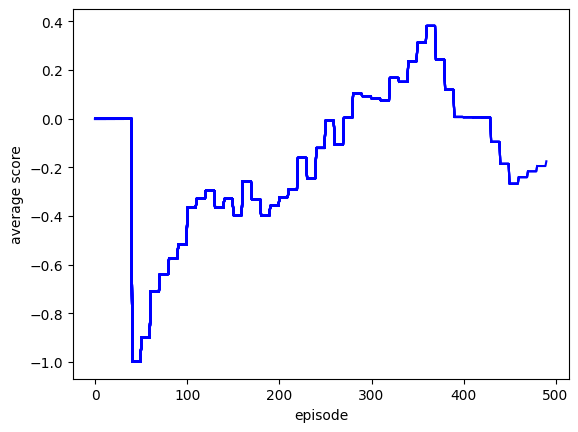

In [ ]:
for e in range(num_episode):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        step_count = 0

        while not done:
            # if agent.render:
            #     env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            score += reward

            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)

            # # epsilon 감소 주기 조정(epsilon이 안 줄어들어서 추가!)
            # if agent.epsilon > agent.epsilon_min:
            #     agent.epsilon *= agent.epsilon_decay
            #     agent.epsilon = max(agent.epsilon, agent.epsilon_min) # epsilon_min보다 작아지지 않도록

            # 매 4 타임스텝마다 학습
            # if len(agent.memory) >= agent.train_start and step_count % 4 == 0:
            #     agent.train_model()
            agent.train_model()

            state = next_state
            step_count += 1  # 타임스텝 카운터 증가

            if done:
                # 매 10 에피소드마다 타깃 모델을 업데이트
                if e % 10 == 0:
                    agent.update_target_model()

                # 에피소드 결과 출력을 10 에피소드마다 한 번씩
                if e % 10 == 0:
                    score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                    print("episode: {:3d} | score avg: {:3.2f} | memory length: {:4d} | epsilon: {:.4f}".format(e, score_avg, len(agent.memory), agent.epsilon))

                agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

                # 그래프 업데이트
                scores.append(score_avg)
                episodes.append(e)
                if e % 10 == 0:
                    plt.plot(episodes, scores, 'b')
                    plt.xlabel("episode")
                    plt.ylabel("average score")
                    # pylab.savefig("./save_graph/graph.png")

<ipython-input-207-2448c51d4df5>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # 배치 차원 추가


Episode: 1, Score: 0, Cumulative Score: 0
Episode: 2, Score: 1, Cumulative Score: 1
Episode: 3, Score: 1, Cumulative Score: 2
Episode: 4, Score: 0, Cumulative Score: 2
Episode: 5, Score: 1, Cumulative Score: 3
Episode: 6, Score: 1, Cumulative Score: 4
Episode: 7, Score: 0, Cumulative Score: 4
Episode: 8, Score: 1, Cumulative Score: 5
Episode: 9, Score: 0, Cumulative Score: 5
Episode: 10, Score: 0, Cumulative Score: 5
Episode: 11, Score: 1, Cumulative Score: 6
Episode: 12, Score: 1, Cumulative Score: 7
Episode: 13, Score: 1, Cumulative Score: 8
Episode: 14, Score: 0, Cumulative Score: 8
Episode: 15, Score: 1, Cumulative Score: 9
Episode: 16, Score: 1, Cumulative Score: 10
Episode: 17, Score: 1, Cumulative Score: 11
Episode: 18, Score: 0, Cumulative Score: 11
Episode: 19, Score: 0, Cumulative Score: 11
Episode: 20, Score: 1, Cumulative Score: 12
Episode: 21, Score: 1, Cumulative Score: 13
Episode: 22, Score: 1, Cumulative Score: 14
Episode: 23, Score: 1, Cumulative Score: 15
Episode: 24,

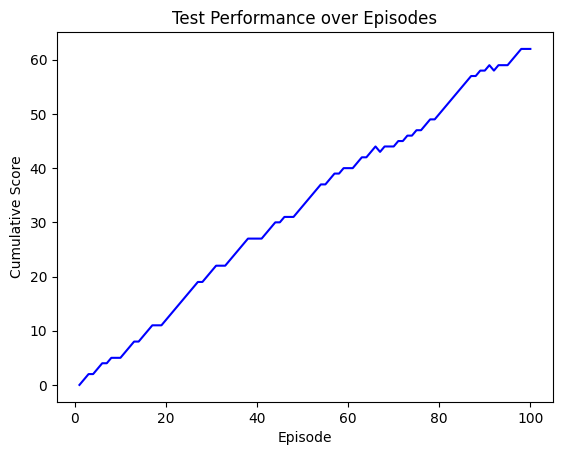

In [ ]:
import matplotlib.pyplot as plt

def test_agent(agent, env, num_episodes=100):
    scores = []
    cumulative_scores = []  # 누적 점수를 저장할 리스트
    total_score = 0  # 총 점수를 초기화

    for e in range(num_episodes):
        done = False
        score = 0
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        while not done:
            env.render()  # 시각화
            action = agent.get_action(state)  # 행동 선택
            next_state, reward, done = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            score += reward  # 점수 누적
            state = next_state

        total_score += score  # 총 점수에 현재 점수를 추가
        scores.append(score)
        cumulative_scores.append(total_score)  # 누적 점수 기록
        print(f"Episode: {e + 1}, Score: {score}, Cumulative Score: {total_score}")

    # 테스트 완료 후 그래프 생성
    plt.plot(range(1, num_episodes + 1), cumulative_scores, 'b')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Score")
    plt.title("Test Performance over Episodes")
    plt.show()

# 호출
test_agent(agent, env)

1. 내용이 달라지면 한 줄 띄어씀(가독성)
2. 주석 1)설명은 위에 2)디버깅 중 확인해야할 부분은 해당 코드 오른쪽에 작성
3. 변수명에는 최대한 숫자를 넣지 않음
4. 변수명에 _는 하나만 사용
5. 변수명에 대소문자를 섞지 않음
6. 단계를 최대한 적게 할 것